In [1]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import shutil
from shutil import copyfile
import pathlib
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
IMAGE_SIZE = 256


In [3]:
def createMask(img):
    mask = np.full((IMAGE_SIZE, IMAGE_SIZE, 3), 0,
                   np.uint8)  # white background
    h1 = np.random.randint(IMAGE_SIZE*0.75, IMAGE_SIZE*0.9)
    h2 = np.random.randint(IMAGE_SIZE*0.5, IMAGE_SIZE*0.75)

    pts = np.array([[0, h1], [IMAGE_SIZE, h2], [IMAGE_SIZE, IMAGE_SIZE], [
                   0, IMAGE_SIZE], [0, h1]], np.int32)
    cv2.fillConvexPoly(mask, pts, (255, 255, 255))
    #
    # img_masked = img.copy()
    # img_masked[mask == 0] = 255
    #
    img_masked = cv2.bitwise_or(img, mask)
    return img_masked


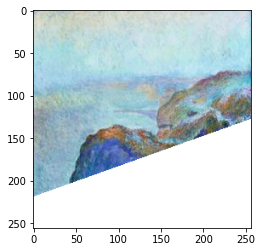

In [4]:
# load_img('./monet_jpg/000c1e3bff.jpg')#
test = cv2.imread('./images/monet_jpg/000c1e3bff.jpg', cv2.IMREAD_COLOR)
masked = createMask(test)
plt.imshow(masked)
#
# path_test_image = 'images/monet_jpg/000c1e3bff.jpg'
# print(f'-> {path_test_image}')
# test_image = load_and_process_image(path_test_image)
# test_image = tf.reshape(test_image,(1,)+test_image.shape)
# predict = model.predict(test_image)
# predict = tf.squeeze(predict,axis=0)
# plt.imshow(predict)



In [5]:
dir_base = 'images'
dir_monet = os.path.join(dir_base, 'monet_jpg')
dir_photo = os.path.join(dir_base, 'photo_jpg')


In [6]:
shutil.rmtree(os.path.join(dir_base, 'testing'))
shutil.rmtree(os.path.join(dir_base, 'training'))


In [7]:
def make_training_testing_dirs(BASE_DIR):
    if os.path.exists(BASE_DIR):
        shutil.rmtree(BASE_DIR)
    os.mkdir(BASE_DIR)

    dir_data = os.path.join(BASE_DIR, 'masked')
    if os.path.exists(dir_data):
        shutil.rmtree(dir_data)
    os.mkdir(dir_data)

    dir_label = os.path.join(BASE_DIR, 'labels')
    if os.path.exists(dir_label):
        shutil.rmtree(dir_label)
    os.mkdir(dir_label)
    return dir_data, dir_label


In [8]:

dir_training_masked, dir_training_labels = make_training_testing_dirs(
    os.path.join(dir_base, 'training'))
dir_testing_masked, dir_testing_labels = make_training_testing_dirs(
    os.path.join(dir_base, 'testing'))


In [9]:
# shutil.copyfile('./images/monet_jpg/000c1e3bff.jpg','./images/training/labels/000c1e3bff.jpg')
# cv2.imwrite('./images/masked_monet/000c1e3bff.jpg',masked)


In [10]:
def create_data_label_data(SOURCE_DIR, DATA_DIR, LABEL_DIR, LIST):
    for file in LIST:
        file_path = os.path.join(SOURCE_DIR, file)
        file_size = os.path.getsize(file_path)
        data_file_path = os.path.join(DATA_DIR, file)
        label_file_path = os.path.join(LABEL_DIR, file)
        if (file_size == 0):
            print(f'{file}is zero length, so ignoring.')
        else:
            image = cv2.imread(file_path, cv2.IMREAD_COLOR)
            # create masked image
            masked_image = createMask(image)
            # write image to masked folder
            cv2.imwrite(data_file_path, masked_image)
            # copy origin image to label folder
            copyfile(file_path, label_file_path)

In [11]:
def split_data(SOURCE_DIR, SPLIT_SIZE):
    list_datasource = os.listdir(SOURCE_DIR)
    len_training = round(len(list_datasource)*SPLIT_SIZE)
    list_training = list_datasource[:len_training]
    list_testing = list_datasource[len_training:]
    print(f'len source = {len(list_datasource)}  \nlen trainint = {len_training}  \nlen listTraining = {len(list_training)} \nlen listTesting = {len(list_testing)}')
    create_data_label_data(SOURCE_DIR, dir_training_masked,
                           dir_training_labels, list_training)
    create_data_label_data(SOURCE_DIR, dir_testing_masked,
                           dir_testing_labels, list_testing)


In [12]:
# split data
SPLIT_RATE = 0.7
list_monet = os.listdir(dir_monet)
list_photo = os.listdir(dir_photo)
split_data(dir_monet, SPLIT_RATE)
split_data(dir_photo, SPLIT_RATE)


len source = 300  
len trainint = 210  
len listTraining = 210 
len listTesting = 90
len source = 7038  
len trainint = 4927  
len listTraining = 4927 
len listTesting = 2111


In [13]:
class inpaintingModel:
    '''
    Build UNET like model for image inpaining task.
    '''

    def prepare_model(self, input_size=(IMAGE_SIZE, IMAGE_SIZE, 3)):
        inputs = tf.keras.layers.Input(input_size)

        conv1, pool1 = self.__ConvBlock(
            32, (3, 3), (2, 2), 'relu', 'same', inputs)
        conv2, pool2 = self.__ConvBlock(
            64, (3, 3), (2, 2), 'relu', 'same', pool1)
        conv3, pool3 = self.__ConvBlock(
            128, (3, 3), (2, 2), 'relu', 'same', pool2)
        conv4, pool4 = self.__ConvBlock(
            256, (3, 3), (2, 2), 'relu', 'same', pool3)

        conv5, up6 = self.__UpConvBlock(
            512, 256, (3, 3), (2, 2), (2, 2), 'relu', 'same', pool4, conv4)
        conv6, up7 = self.__UpConvBlock(
            256, 128, (3, 3), (2, 2), (2, 2), 'relu', 'same', up6, conv3)
        conv7, up8 = self.__UpConvBlock(
            128, 64, (3, 3), (2, 2), (2, 2), 'relu', 'same', up7, conv2)
        conv8, up9 = self.__UpConvBlock(
            64, 32, (3, 3), (2, 2), (2, 2), 'relu', 'same', up8, conv1)

        conv9 = self.__ConvBlock(
            32, (3, 3), (2, 2), 'relu', 'same', up9, False)

        outputs = tf.keras.layers.Conv2D(
            3, (3, 3), activation='sigmoid', padding='same')(conv9)

        return tf.keras.models.Model(inputs=[inputs], outputs=[outputs])

    def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
        conv = tf.keras.layers.Conv2D(
            filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = tf.keras.layers.Conv2D(
            filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        if pool_layer:
            pool = tf.keras.layers.MaxPooling2D(pool_size)(conv)
            return conv, pool
        else:
            return conv

    def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
        conv = tf.keras.layers.Conv2D(
            filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = tf.keras.layers.Conv2D(
            filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        up = tf.keras.layers.Conv2DTranspose(
            filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
        up = tf.keras.layers.concatenate([up, shared_layer], axis=3)

        return conv, up


In [14]:
# For more information into formulation: https://www.youtube.com/watch?v=AZr64OxshLo
# Metric
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (tf.keras.backend.sum(y_true_f + y_pred_f))


In [15]:
model = inpaintingModel().prepare_model()
# metrics=[dice_coef]
model.compile(optimizer='adam', loss='mean_absolute_error')
# tf.keras.utils.plot_model(model, show_shapes=True, dpi=76, to_file='model_v1.png')


2022-09-11 10:26:11.569839: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
# image generator
TRAINING_DIR = os.path.join(dir_base, 'training')
TRAINING_MASKED_DIR = os.path.join(TRAINING_DIR, 'masked')
TRAINING_LABEL_DIR = os.path.join(TRAINING_DIR, 'labels')
TESTING_DIR = "/images/testing/"
AUTOTUNE = tf.data.experimental.AUTOTUNE


In [17]:
os.listdir(TRAINING_MASKED_DIR)


['5a384bf8d9.jpg',
 'bb15fcc4ff.jpg',
 '39c1270676.jpg',
 '506fdcb3c1.jpg',
 '63f6cea734.jpg',
 '7b95afc20a.jpg',
 '0723d52098.jpg',
 '3be1aea5fc.jpg',
 '114692dc5b.jpg',
 'd665568cdf.jpg',
 'ada64f6f98.jpg',
 '7a317ade8c.jpg',
 '9c92f8345f.jpg',
 'f40b429650.jpg',
 'f298108b32.jpg',
 '1f22663e72.jpg',
 '6f8cb591c0.jpg',
 '8f9cc89fc1.jpg',
 '9079fe9d9c.jpg',
 'f6798eb074.jpg',
 '9588a52282.jpg',
 '0cdfbb28e6.jpg',
 '1467b3a6ac.jpg',
 'd5a509f069.jpg',
 '75ae690a9b.jpg',
 'a777303bee.jpg',
 '45ae43ca11.jpg',
 '27b87e7785.jpg',
 '94af688583.jpg',
 'b4cc9f5870.jpg',
 '43519ebdda.jpg',
 'eb48b08b2c.jpg',
 'aea3c83ebe.jpg',
 '03bac83f64.jpg',
 '8c58319212.jpg',
 'ef77fe0cfc.jpg',
 'abe813f1cb.jpg',
 '9b3053dc34.jpg',
 'be5a727d8a.jpg',
 '1789a61138.jpg',
 '6728f4bba7.jpg',
 'f40b719930.jpg',
 '50855dd324.jpg',
 '8e876bd586.jpg',
 '95c438e906.jpg',
 '8b997cbee6.jpg',
 'b3bfca1f8b.jpg',
 '5602c749d0.jpg',
 '99283f98de.jpg',
 'b81b0d4833.jpg',
 '6a19d6ed16.jpg',
 'b2cbeec8f9.jpg',
 'f53328c040

In [18]:
def load_and_process_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image, tf.float32)
    image /= 255.0
    return image


In [19]:
# list_training_images = os.listdir(TRAINING_MASKED_DIR)

path_training_images = pathlib.Path(TRAINING_MASKED_DIR)
list_path_training_images = list(path_training_images.glob('*.jpg'))
list_training_images = [str(path) for path in list_path_training_images]

path_training_labels = pathlib.Path(TRAINING_LABEL_DIR)
list_path_training_labels = list(path_training_labels.glob('*.jpg'))
list_training_labels = [str(path) for path in list_path_training_labels]


In [20]:
dataset_path_training_masked = tf.data.Dataset.from_tensor_slices(
    list_training_images)
masked_image_dataset = dataset_path_training_masked.map(
    load_and_process_image, num_parallel_calls=AUTOTUNE)


In [21]:
dataset_path_training_label = tf.data.Dataset.from_tensor_slices(
    list_training_labels)
label_image_dataset = dataset_path_training_label.map(
    load_and_process_image, num_parallel_calls=AUTOTUNE)


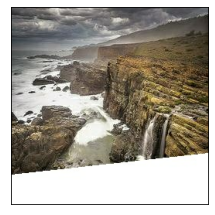

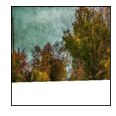

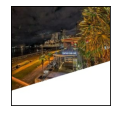

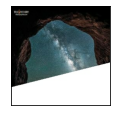

In [22]:
plt.figure(figsize=(8, 8))
for n, image in enumerate(masked_image_dataset.take(4)):
    plt.subplot(2, 2, n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.show()


In [23]:
dataset_masked_label = tf.data.Dataset.zip(
    (masked_image_dataset, label_image_dataset))


In [24]:
BATCH_SIZE = 32
image_count = len(list_training_images)
ds = dataset_masked_label.shuffle(buffer_size=image_count)
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)


In [25]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [26]:
history = model.fit(ds,
                    epochs=25,
                    use_multiprocessing=True,
                    )


Epoch 1/25
161/161 [==============================] - 2067s 13s/step - loss: 0.1361
Epoch 2/25
161/161 [==============================] - 2071s 13s/step - loss: 0.0692
Epoch 3/25
161/161 [==============================] - 3315s 21s/step - loss: 0.0588
Epoch 4/25
161/161 [==============================] - 2314s 14s/step - loss: 0.0544
Epoch 5/25
161/161 [==============================] - 2080s 13s/step - loss: 0.0521
Epoch 6/25
161/161 [==============================] - 2091s 13s/step - loss: 0.0514
Epoch 7/25
161/161 [==============================] - 2069s 13s/step - loss: 0.0513
Epoch 8/25
161/161 [==============================] - 2052s 13s/step - loss: 0.0469
Epoch 9/25
161/161 [==============================] - 2083s 13s/step - loss: 0.0476
Epoch 10/25
161/161 [==============================] - 2589s 16s/step - loss: 0.0494
Epoch 11/25
161/161 [==============================] - 2052s 13s/step - loss: 0.0461
Epoch 12/25
161/161 [==============================] - 2334s 14s/step - lo

2022-09-11 19:41:13.584895: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 4572 of 5137
2022-09-11 19:41:15.205612: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


161/161 [==============================] - 4463s 28s/step - loss: 0.0447
Epoch 15/25
161/161 [==============================] - 2022s 13s/step - loss: 0.0443
Epoch 16/25
161/161 [==============================] - 2058s 13s/step - loss: 0.0434
Epoch 17/25
161/161 [==============================] - 2876s 18s/step - loss: 0.0428
Epoch 18/25
161/161 [==============================] - 2053s 13s/step - loss: 0.0423
Epoch 19/25
161/161 [==============================] - 2041s 13s/step - loss: 0.0426
Epoch 20/25
161/161 [==============================] - 31442s 196s/step - loss: 0.0421
Epoch 21/25
161/161 [==============================] - 2005s 12s/step - loss: 0.0420
Epoch 22/25
161/161 [==============================] - 2219s 14s/step - loss: 0.0408
Epoch 23/25
161/161 [==============================] - 10748s 67s/step - loss: 0.0408
Epoch 24/25
161/161 [==============================] - 2568s 16s/step - loss: 0.0409
Epoch 25/25
161/161 [==============================] - 3079s 19s/step - lo

In [27]:
TESTING_DIR = os.path.join(dir_base, 'testing')
TESTING_MASKED_DIR = os.path.join(TESTING_DIR, 'masked')



path_testing_labels = pathlib.Path(TESTING_MASKED_DIR)
list_path_testing_images = list(path_testing_labels.glob('*.jpg'))
# path_test = list_path_testing_images[:4]

str_path_testing = [str(path) for path in list_path_testing_images]
# path_test_image = str_path_test[3]
# print(f'-> {path_test_image}')
# test_image = load_and_process_image(path_test_image)
# test_image = tf.reshape(test_image,(1,)+test_image.shape)


In [28]:
# path_test_image = 'images/testing/masked/00.jpg'
# print(f'-> {path_test_image}')
# test_image = load_and_process_image(path_test_image)
# test_image = tf.reshape(test_image,(1,)+test_image.shape)
# predict = model.predict(test_image)
# predict = tf.squeeze(predict,axis=0)
# plt.imshow(predict)



-> images/testing/masked/00.jpg


2022-09-12 14:27:17.726748: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: images/testing/masked/00.jpg; No such file or directory


NotFoundError: images/testing/masked/00.jpg; No such file or directory [Op:ReadFile]

-> images/testing/masked/92884da831.jpg
images/testing/labels/92884da831.jpg
1/1 [==============================] - 1s 522ms/step
-> images/testing/masked/aa64f54007.jpg
images/testing/labels/aa64f54007.jpg
1/1 [==============================] - 0s 141ms/step
-> images/testing/masked/281b790739.jpg
images/testing/labels/281b790739.jpg
1/1 [==============================] - 0s 143ms/step
-> images/testing/masked/8ea3121111.jpg
images/testing/labels/8ea3121111.jpg
1/1 [==============================] - 0s 145ms/step
-> images/testing/masked/9dad30bdf5.jpg
images/testing/labels/9dad30bdf5.jpg
1/1 [==============================] - 0s 142ms/step


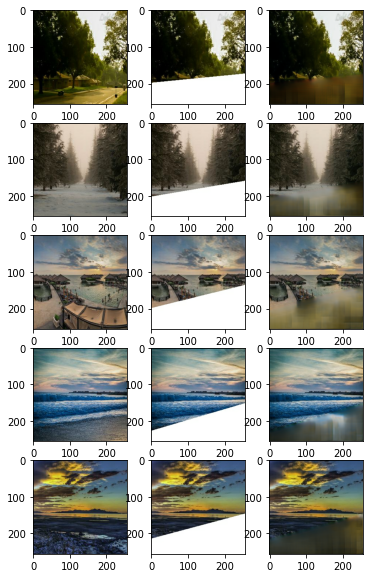

In [29]:
import random
row = 5

def get_random_testing_path():
    path_test_image = random.choice(str_path_testing)
    print(f'-> {path_test_image}')
    test_image = load_and_process_image(path_test_image)
    test_image = tf.reshape(test_image,(1,)+test_image.shape)
    #
    test_label_path = path_test_image.replace('masked','labels')
    print(test_label_path)
    test_label_image = load_and_process_image(test_label_path)
    return test_image,test_label_image



fig, axs = plt.subplots(nrows=row, ncols=3,figsize=(6, 2*row))
for i in range(row):
    testing_image,testing_label = get_random_testing_path()
    # print(f'testing_image  = {testing_image.shape}')
    # print(f'testing_label  = {testing_label.shape}')

    predict = model.predict(testing_image)
    predict = tf.squeeze(predict,axis=0)
    axs[i][0].imshow(testing_label)
    axs[i][1].imshow(tf.squeeze(testing_image))
    axs[i][2].imshow(predict)

plt.show()